In this notebook we attempted to do a linear combination of feature graphs in order to construct the graph. The idea was to use a grid search to find a combination which would optimize the weights. The output was given by heat diffusion from a starting node (course of interest) compared to the estimated probability of the other courses being taken if the course of interest was. 

In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import pickle
from pygsp import graphs, filters, plotting
from scipy.spatial import distance
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm
plt.rcParams['figure.figsize'] = (17, 5)
plotting.BACKEND = 'matplotlib'

do_prints = False
random = True

plt.rcParams['figure.figsize'] = (17, 5)
plotting.BACKEND = 'matplotlib'
%matplotlib inline

2018-01-22 16:16:48,701:[WARNING](pygsp.graphs.nngraphs.nngraph.<module>): Cannot import pyflann (used for faster kNN computations): Traceback (most recent call last):
  File "C:\Users\Thomas\Anaconda3\lib\site-packages\pygsp\graphs\nngraphs\nngraph.py", line 14, in <module>
    import pyflann as pfl
  File "C:\Users\Thomas\Anaconda3\lib\site-packages\pyflann\__init__.py", line 27, in <module>
    from pyflann.index import *
  File "C:\Users\Thomas\Anaconda3\lib\site-packages\pyflann\index.py", line 27, in <module>
    from pyflann.bindings.flann_ctypes import *
  File "C:\Users\Thomas\Anaconda3\lib\site-packages\pyflann\bindings\__init__.py", line 30, in <module>
    from pyflann.bindings.flann_ctypes import *
  File "C:\Users\Thomas\Anaconda3\lib\site-packages\pyflann\bindings\flann_ctypes.py", line 171, in <module>
    raise ImportError('Cannot load dynamic library. Did you compile FLANN?')
ImportError: Cannot load dynamic library. Did you compile FLANN?



## 1. Loading the Feature Graphs

In [2]:
pkl_file = open(os.path.join(os.getcwd(), 'Graphs','students_graph_STI.pkl'), 'rb')
students_graph = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open(os.path.join(os.getcwd(), 'Graphs','assistants_graph_STI.pkl'), 'rb')
assistants_graph = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open(os.path.join(os.getcwd(), 'Graphs','prof_graph_STI.pkl'), 'rb')
prof_graph = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open(os.path.join(os.getcwd(), 'Graphs','section_graph_STI.pkl'), 'rb')
sections_graph = pickle.load(pkl_file)
pkl_file.close()

#pkl_file = open(os.path.join(os.getcwd(), 'Graphs','topics_graph.pkl'), 'rb')
#topics_graph = pickle.load(pkl_file)
#pkl_file.close()

pkl_file = open(os.path.join(os.getcwd(), 'Graphs','req_course_same_req_graph_STI.pkl'), 'rb')
course_same_req_graph = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open(os.path.join(os.getcwd(), 'Graphs','req_course_to_req_graph_STI.pkl'), 'rb')
course_to_req_graph = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open(os.path.join(os.getcwd(), 'Graphs','req_same_course_graph_STI.pkl'), 'rb')
same_course_req_graph = pickle.load(pkl_file)
pkl_file.close()

if do_prints:
    print("students ", np.shape(students_graph))
    print("assistants ", np.shape(assistants_graph))
    print("prof ", np.shape(prof_graph))
    print("sections ", np.shape(sections_graph))
    #print("topics ", np.shape(topics_graph))
    print("course same req ", np.shape(course_same_req_graph))
    print("course to req ", np.shape(course_to_req_graph))
    print("same course req ", np.shape(same_course_req_graph))

assert np.shape(students_graph) == np.shape(assistants_graph)
assert np.shape(assistants_graph) == np.shape(prof_graph)
assert np.shape(prof_graph) == np.shape(sections_graph)
#assert np.shape(sections_graph) == np.shape(topics_graph)
#assert np.shape(topics_graph) == np.shape(course_same_req_graph)
assert np.shape(sections_graph) == np.shape(course_same_req_graph)
assert np.shape(course_same_req_graph) == np.shape(course_to_req_graph)
assert np.shape(course_to_req_graph) == np.shape(same_course_req_graph)

In [3]:
courses = pd.read_pickle("../data/cleaned_courses_STI.pickle")
full_courses_list = courses.index.tolist()

## 2. Rescaling the Data

In [4]:
weight_matrices = [students_graph, assistants_graph, prof_graph, sections_graph, course_same_req_graph, course_to_req_graph, same_course_req_graph]

for i in range(len(weight_matrices)):
    # Set the diagonal of the matrix to 0
    np.fill_diagonal(weight_matrices[i], 0)
    max_val = np.max(np.reshape(weight_matrices[i], (-1,1)))
    weight_matrices[i] = weight_matrices[i]/np.max(np.reshape(weight_matrices[i], (-1,1)))

In [5]:
def create_graph(mat):
    
    # Create the graph
    G = graphs.Graph(mat)
    G.compute_laplacian("normalized")
    G.compute_fourier_basis()
    return G

## 4. Diffusion

In [6]:
def heat_diffusion(G, courses, tau):
    
    # Create the heat diffusion filter
    filt = filters.Heat(G, tau)
    
    # Plot the response of the filter
    #y = filt.evaluate(G.e)
    #plt.plot(G.e, y[0])
    
    # Create the signal for the given graph
    signal = np.zeros(G.N)
    
    for course in courses:
        NODE = np.where(np.asarray(full_courses_list) == course)[0]
        signal[NODE] = 1

    # Apply the filter to the signal
    filtered_s = filt.filter(signal)

    return filtered_s

In [7]:
def diffusion(weight_mat, list_loved_courses, n_result_courses, tau_filter):
    # Define the index of the loved courses to hgighlight them later.
    NODE = []
    for i in range(0,len(list_loved_courses)):
        if (len(np.where(np.asarray(full_courses_list) == list_loved_courses[i])[0])==0):
            print("ERROR! Course loved is not in the list of the courses.")
            return
        NODE.append(np.where(np.asarray(full_courses_list) == list_loved_courses[i])[0][0])
    
    # Create the graph and do the diffusion on it.
    G_diffusion = create_graph(weight_mat)
    filtered_signals = heat_diffusion(G_diffusion,list_loved_courses,tau_filter)
    # Plot the diffusion
    G_diffusion.set_coordinates("spring")#G_diffusion.U[:,1:3])
    G_diffusion.plot_signal(filtered_signals, vertex_size=50, highlight = NODE, )
    
    # Create the list of courses ordered with their values found by the diffusion. 
    filtered_signals_int = list(filtered_signals)
    courses_list = []
    if(n_result_courses > len(filtered_signals_int)):
        n_result_courses = len(filtered_signals_int)
    for i in range(0,n_result_courses):
        course_code = full_courses_list[filtered_signals_int.index(max(filtered_signals_int))]
        courses_list.append(courses[courses.index.str.endswith(course_code)].CourseTitleFR.tolist()[0])
        filtered_signals_int[filtered_signals_int.index(max(filtered_signals_int))] = -1
    return courses_list

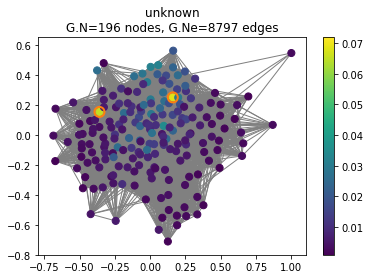

In [20]:
weight_different_graph = [0.2,0,0,0,0,0,1] # [0.5?,0,0,0 -same students-,0,$,1]
diffusion_graph = weight_different_graph[0]*weight_matrices[0]
for i in range(1, len(weight_matrices)):
    diffusion_graph = diffusion_graph + weight_different_graph[i]*weight_matrices[i]
recommanded_courses = diffusion(diffusion_graph,["EE-535", "EE-420"],7,4)

In [21]:
recommanded_courses

['Analog circuits design I',
 'Nanoelectronics',
 'HF and VHF circuits and techniques I',
 'Lab in EDA based design',
 'Lab in acoustics',
 'Analog circuits design II',
 'Industrial electronics I']